In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import PorterStemmer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
stop = stopwords.words('english')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
dataset1 = pd.read_csv('train_sms_mine.csv')

In [3]:
dataset1.head(5)

,Label,Message
0,Delivery,"Dear Guest, Thanks for choosing The Edison. Or..."
1,Hotel,Welcome to Southern University at Shreveport R...
2,Payment,Bill dated 2013-01-14 for Rs 626 has been gene...
3,Payment,Bill dated 2014-11-30 for Rs 323 has been gene...
4,Appointment,"DEAR Zachary, THANK YOU FOR YOUR BOOKING (ORDE..."


In [4]:
dataset1["Label"]

0           Delivery
1              Hotel
2            Payment
3            Payment
4        Appointment
            ...     
41995            ham
41996           spam
41997            ham
41998           spam
41999           spam
Name: Label, Length: 42000, dtype: object

In [5]:
# from sklearn.utils import shuffle
# dataset = shuffle(dataset)
# dataset.reset_index(drop=True)
# dataset.head
dataset = pd.DataFrame(columns=['Label','Message'])
labels = []
Messages = []

for i in range(0 ,15000):
  labels.append(dataset1["Label"][i])
  Messages.append(dataset1["Message"][i])

In [6]:
dataset["Label"] = labels
dataset["Message"] = Messages

In [7]:
dataset.head

<bound method NDFrame.head of              Label                                            Message
0         Delivery  Dear Guest, Thanks for choosing The Edison. Or...
1            Hotel  Welcome to Southern University at Shreveport R...
2          Payment  Bill dated 2013-01-14 for Rs 626 has been gene...
3          Payment  Bill dated 2014-11-30 for Rs 323 has been gene...
4      Appointment  DEAR Zachary, THANK YOU FOR YOUR BOOKING (ORDE...
...            ...                                                ...
14995         info  Appointment with Dr Tristan in ALIKE on 2009-0...
14996         info  Welcome to Fort Huachuca R.No. 450, 276, 223 C...
14997         info  [Copa d' Oro] Hi Alan, your reservation is con...
14998         spam  Take your career to new heights in 2016! Explo...
14999         spam  Dear Member, you are now unsubscribed from our...

[15000 rows x 2 columns]>

In [8]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "cause": "because", "could've": "could have","this's" : "this is"}

In [9]:
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
  def replace(match):
    return contractions[match.group(0)]
  return contractions_re.sub(replace, text)

In [10]:
for msg in dataset["Message"] :
  replace_contractions(msg)

In [11]:
def clean_data(x):
  punctuation = '.!"#$%&()*+-/:,;<=>?@[\\]^_`{|}~'
  x = x.apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))
  x = x.str.lower()
  x = x.str.replace("[0-9]", " ")
  x = x.apply(lambda x: ' '.join(x.split()))
  return x

In [12]:
cleaned = clean_data(dataset["Message"])

In [13]:
cleaned2=[]
for msg in cleaned:
  cleaned2.append(nltk.word_tokenize(msg))

In [14]:
dataset["Message"] = cleaned2

In [15]:
# dataset["Message"] = cleaned
# dataset.head

In [16]:
dataset["Message"].apply(lambda x: [item for item in x if item not in stop])

0        [dear, guest, thanks, choosing, edison, order,...
1        [welcome, southern, university, shreveport, rn...
2        [bill, dated, rs, generated, aircel, fixedline...
3        [bill, dated, rs, generated, reliance, fixedli...
4        [dear, zachary, thank, booking, order, id, ord...
                               ...                        
14995    [appointment, dr, tristan, alike, confirmed, q...
14996          [welcome, fort, huachuca, rno, chin, chout]
14997    [copa, ', oro, hi, alan, reservation, confirme...
14998    [take, career, new, heights, explore, immigrat...
14999    [dear, member, unsubscribed, messagesto, opt, ...
Name: Message, Length: 15000, dtype: object

In [17]:
from keras.preprocessing.text import Tokenizer
MAX_NB_WORDS = 5000
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 50

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”’\'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—', lower=True)
# tokenizer = pickle.load(open('_tokenizer.pkl', 'rb'))
tokenizer.fit_on_texts(dataset['Message'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 12724 unique tokens.


In [18]:
X = tokenizer.texts_to_sequences(dataset['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (15000, 25)


In [19]:
Y = pd.get_dummies(dataset['Label'])
# print('Shape of label tensor:', Y.shape)

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(10500, 25) (10500, 15)
(4500, 25) (4500, 15)


In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l1

In [22]:
model = Sequential()
model.add(Dense(75, input_dim=X_train.shape[1], activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(Y.shape[1], activation='sigmoid'))

In [23]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                1950      
_________________________________________________________________
dropout_1 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 15)               

In [25]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0.001)
history = model.fit(X_train, Y_train,
                   
                    batch_size=50, epochs=50, validation_split=0.1,callbacks=[callback])

Train on 9450 samples, validate on 1050 samples
Epoch 1/50
9450/9450 [==============================] - 1s 146us/step - loss: 0.3280 - accuracy: 0.8719 - val_loss: 0.1559 - val_accuracy: 0.9453
Epoch 2/50
9450/9450 [==============================] - 1s 101us/step - loss: 0.1705 - accuracy: 0.9414 - val_loss: 0.1052 - val_accuracy: 0.9634
Epoch 3/50
9450/9450 [==============================] - 1s 102us/step - loss: 0.1336 - accuracy: 0.9519 - val_loss: 0.0839 - val_accuracy: 0.9715
Epoch 4/50
9450/9450 [==============================] - 1s 102us/step - loss: 0.1144 - accuracy: 0.9579 - val_loss: 0.0753 - val_accuracy: 0.9738
Epoch 5/50
9450/9450 [==============================] - 1s 100us/step - loss: 0.1037 - accuracy: 0.9614 - val_loss: 0.0704 - val_accuracy: 0.9745
Epoch 6/50
9450/9450 [==============================] - 1s 101us/step - loss: 0.0966 - accuracy: 0.9646 - val_loss: 0.0651 - val_accuracy: 0.9782
Epoch 7/50
9450/9450 [==============================] - 1s 107us/step - loss

In [26]:
score, acc = model.evaluate(X_test, Y_test,
                            batch_size=100)
print('Test score:', score)
print('Test accuracy:', acc)

4500/4500 [==============================] - 0s 20us/step
Test score: 0.05131675708625052
Test accuracy: 0.9837480187416077


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


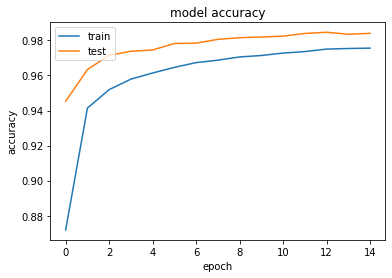

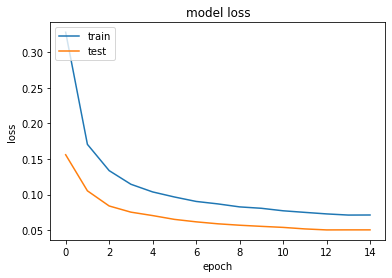

In [27]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

4500/4500 [==============================] - 0s 62us/step
Test set
  Loss: 0.051
  Accuracy: 0.984


In [29]:
def sample_predict(sample_pred_text):
  new_sms = [sample_pred_text]
  seq = tokenizer.texts_to_sequences(new_sms)
  padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
  predictions = model.predict(padded)
  
  return np.argmax(predictions)


In [30]:
sample_predict("True Value : Service of your car KA61H6744 is due in 37 days on 2010-11-22. Please contact us at 9228374456 to book a service.")

5

In [31]:
Y

,Appointment,Bus,Cab,Delivery,Expiry,Flight,Hotel,Movie,Payment,PickUp,Reservation,Train,ham,info,spam
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
14996,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
14997,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
14998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
